## Chapter 6 Algorithm chains and pipeline

In [25]:
import numpy as np 
import pandas as pd 

from sklearn.svm import SVC 
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 

In [3]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
cancer.data, cancer.target, random_state = 0)

In [6]:
X_train[:1], len(X_train), len(X_train[0])

(array([[1.185e+01, 1.746e+01, 7.554e+01, 4.327e+02, 8.372e-02, 5.642e-02,
         2.688e-02, 2.280e-02, 1.875e-01, 5.715e-02, 2.070e-01, 1.238e+00,
         1.234e+00, 1.388e+01, 7.595e-03, 1.500e-02, 1.412e-02, 8.578e-03,
         1.792e-02, 1.784e-03, 1.306e+01, 2.575e+01, 8.435e+01, 5.178e+02,
         1.369e-01, 1.758e-01, 1.316e-01, 9.140e-02, 3.101e-01, 7.007e-02]]),
 426,
 30)

In [7]:
# rescale the training data
scaler = MinMaxScaler().fit(X_train)

In [8]:
# rescale the training data 
X_train_scaled = scaler.transform(X_train)
svm = SVC()

#learn on SVM on the scaled training data 
svm.fit(X_train_scaled, y_train)

#scale the test dataa and score the scaled data 
X_test_scaled = scaler.transform(X_test)

print(f"Test Score {svm.score(X_test_scaled, y_test)} ")

Test Score 0.972027972027972 


## parameter selection with preprocessing 

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]
}


In [10]:
grid = GridSearchCV(SVC(), param_grid = param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print(f"Best Cross-validation accuracy: {grid.best_score_}")
print(f"Best Parameters: {grid.best_params_}")
print(f"Test set accuracy: {grid.score(X_test_scaled, y_test)}")

Best Cross-validation accuracy: 0.9812311901504789
Best Parameters: {'C': 1, 'gamma': 1}
Test set accuracy: 0.972027972027972


## Building Pipelines

In [11]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [12]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [13]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


## Using Pipeline in gridsearchcv

In [18]:
param_grid = {
    "svm__C" : [0.001, 0.01, 0.1, 1, 10, 100], 
    "svm__gamma" : [0.001, 0.01, 0.1, 1, 10, 100]
}

In [19]:
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [23]:
print(f"Best cross-validation accuracy {grid.best_score_}")
print(f"Test set score : {grid.score(X_test, y_test)}")
print(f"Best Parameters: {grid.best_params_}")

Best cross-validation accuracy 0.9812311901504789
Test set score : 0.972027972027972
Best Parameters: {'svm__C': 1, 'svm__gamma': 1}


In [27]:
# ILLUSTRATING INFORMATION LEAKAGE
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size = (100, 10000))
y = rnd.normal(size = (100,))



print(len(X), len(X[0]), len(y))



100 10000 100


* Selecting most informative of the 10,000 features using `SelectPercentile` feature selection and the evaluate a Ridge Regressor using cross validations

In [28]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [29]:
select = SelectPercentile(score_func = f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print(f"Shape of X_selected {X_selected.shape}")

Shape of X_selected (100, 500)


In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [31]:
print(f"Cross-validation accuracy (cv only on ridge) {np.mean(cross_val_score(Ridge(), X_selected, y, cv = 5))}")

Cross-validation accuracy (cv only on ridge) 0.9057953065239822


In [32]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                ("ridge", Ridge())])

In [33]:
print(f"Cross-validation accuracy {np.mean(cross_val_score(pipe, X, y, cv = 5))}")

Cross-validation accuracy -0.2465542238495282


## The General Pipeline interface 

In [34]:
from sklearn.pipeline import make_pipeline

#standard syntax
pipe_long = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svm", SVC(C=100))
])

# abbreviated syntax 
pipe_short = make_pipeline(
    MinMaxScaler(), 
    SVC(C=100)
)

In [35]:
print(f"Pipeline Steps \n {pipe_short.steps}")

Pipeline Steps 
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


### Accessing step Attributes

In [41]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data, cancer.target)

#extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print(f"Components.shape: {components.shape}")


Components.shape: (2, 30)


### Accessing Attributes in a pipeline inside GridSearchCV

In [42]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), 
                    LogisticRegression())

In [43]:
param_grid = {
    'logisticregression__C' : [0.01, 0.1, 1, 10, 100]
}

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state = 4
)

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)

/root/miniconda3/envs/tigerAssign1_2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/envs/tigerAssign1_2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [47]:
print(f"Best Estimator : \n{grid.best_estimator_}")

Best Estimator : 
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


In [49]:
print(f"Logistic Regression Steps {grid.best_estimator_.named_steps['logisticregression']}")

Logistic Regression Steps LogisticRegression(C=1)


In [50]:
print(f"Logisitic Regression coefficients {grid.best_estimator_.named_steps['logisticregression'].coef_}")

Logisitic Regression coefficients [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


### Grid-searching Preprocessing steps and model parameters 

In [51]:
from sklearn.datasets import load_boston 
from sklearn.preprocessing import PolynomialFeatures


In [52]:
boston = load_boston()


/root/miniconda3/envs/tigerAssign1_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Califor

In [53]:
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, 
                                                   random_state=0)

In [54]:
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge()
)

In [58]:
param_grid = {
    'polynomialfeatures__degree' : [1, 2, 3],
    'ridge__alpha' : [0.001, 0.01, 1, 10, 100]
}

In [59]:
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train
        )

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 1, 10, 100]})

In [62]:
# improrting matplotlib.pytplot
import matplotlib.pyplot as plt

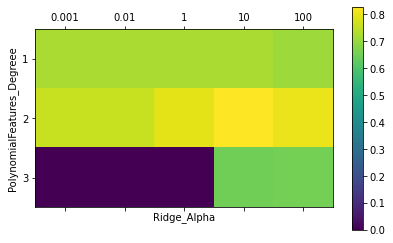

In [63]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), 
           vmin = 0, cmap = 'viridis')
plt.xlabel("Ridge_Alpha")
plt.ylabel("PolynomialFeatures_Degreee")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
          param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [64]:
print(f"best parameters {grid.best_params_}")

best parameters {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [65]:
print(f"Test-set score {grid.score(X_test, y_test)}")

Test-set score 0.7683045464100127


In [66]:
param_grid = {
    'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]
}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)

print(f"Score without poly features: {grid.score(X_test, y_test)}")

Score without poly features: 0.6272671927504455


### Grid-searching which model to use

In [67]:
pipe = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('classifier', SVC())
])

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
param_grid = [
    {
        'classifier' : [SVC()],
        'preprocessing' : [StandardScaler(), None],
        'classifier__gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier': [RandomForestClassifier(n_estimators=100)],
        'preprocessing' : [None], 
        'classifier__max_features' : [1,2, 3]
    }
]

In [73]:
param_grid

[{'classifier': [SVC()],
  'preprocessing': [StandardScaler(), None],
  'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
 {'classifier': [RandomForestClassifier()],
  'preprocessing': [None],
  'classifier__max_features': [1, 2, 3]}]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state = 0
)

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [SVC(C=10, gamma=0.01)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'preprocessing': [StandardScaler(), None]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_features': [1, 2, 3],
                          'preprocessing': [None]}])

In [76]:
print(f"Best Params : \n{grid.best_params_}")
print(f"Best cross-validation score {grid.best_score_}")
print(f"Test-set score {grid.score(X_test, y_test)}")

Best Params : 
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}
Best cross-validation score 0.9858823529411765
Test-set score 0.9790209790209791


In [77]:
pipe = Pipeline([
    ('preprocessing', StandardScaler()),
    ('classifier', SVC())
], memory='cache_folder')

In [78]:
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(memory='cache_folder',
                                steps=[('preprocessing', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [SVC(C=10, gamma=0.01)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'preprocessing': [StandardScaler(), None]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_features': [1, 2, 3],
                          'preprocessing': [None]}])